<a href="https://colab.research.google.com/github/Denniskag/Computer-vision-exam/blob/main/Research_Gap_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

In [2]:
class CustomImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, skip_rate=1, **kwargs):
        super().__init__(*args, **kwargs)
        self.skip_rate = skip_rate

    def _process_frame(self, frame):

        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        equalized_frame = cv2.equalizeHist(gray_frame)

        processed_frame = cv2.cvtColor(equalized_frame, cv2.COLOR_GRAY2RGB)
        return processed_frame

    def _flow_index(self, *args, **kwargs):
        for index in super()._flow_index(*args, **kwargs):
            if index % self.skip_rate == 0:
                yield index

    def __getitem__(self, idx):
        batch_x, batch_y = super().__getitem__(idx)
        processed_batch_x = np.array([self._process_frame(frame) for frame in batch_x])
        return processed_batch_x, batch_y



In [3]:

train_datagen = CustomImageDataGenerator(rescale=1./255,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         skip_rate=2)

training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Computer vision datasets/data_A/train',
                                                 target_size=(64, 64),
                                                 batch_size=32,
                                                 class_mode='binary')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Computer vision datasets/data_A/test',
                                            target_size=(64, 64),
                                            batch_size=32,
                                            class_mode='binary')

Found 5638 images belonging to 2 classes.
Found 1408 images belonging to 2 classes.


In [4]:
def oversample_data(generator):
    X, y = [], []
    for i in range(len(generator)):
        img, label = generator.next()
        X.append(img)
        y.append(label)
    X = np.vstack(X)
    y = np.hstack(y)
    ros = RandomOverSampler()
    X_resampled, y_resampled = ros.fit_resample(X.reshape(len(X), -1), y)
    X_resampled = X_resampled.reshape(-1, 64, 64, 3)
    return X_resampled, y_resampled

In [5]:
X_resampled, y_resampled = oversample_data(training_set)


original_class_counts = Counter(training_set.classes)
resampled_class_counts = Counter(y_resampled)

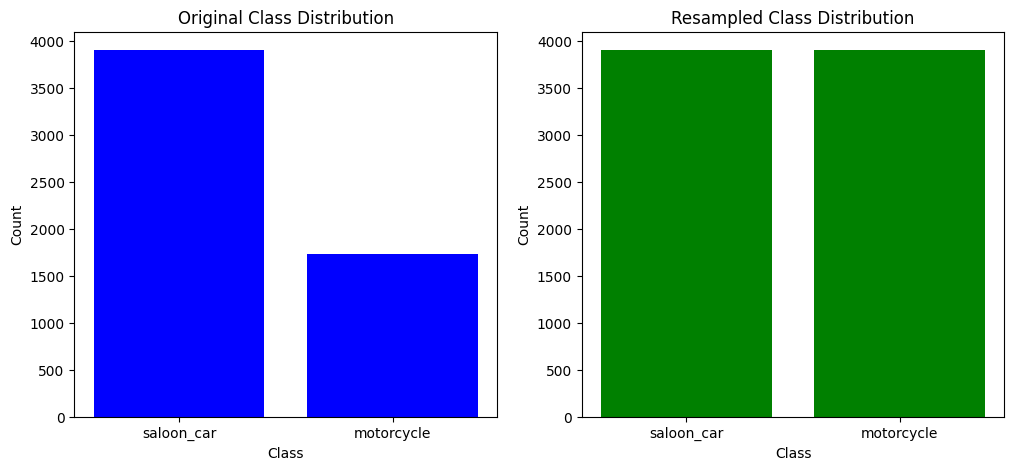

In [6]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(original_class_counts.keys(), original_class_counts.values(), color='blue')
plt.title('Original Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['saloon_car', 'motorcycle'])
plt.subplot(1, 2, 2)
plt.bar(resampled_class_counts.keys(), resampled_class_counts.values(), color='green')
plt.title('Resampled Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['saloon_car', 'motorcycle'])
plt.show()

In [23]:
balanced_train_datagen = ImageDataGenerator(rescale=1./255)
balanced_training_set = balanced_train_datagen.flow(X_resampled, y_resampled, batch_size=32)

In [24]:
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn.fit(x=training_set, validation_data=test_set, epochs=10)

Epoch 1/10
177/177 [==============================] - 35s 190ms/step - loss: 0.2743 - accuracy: 0.8980 - val_loss: 0.1419 - val_accuracy: 0.9560
Epoch 2/10
177/177 [==============================] - 31s 176ms/step - loss: 0.1540 - accuracy: 0.9516 - val_loss: 0.1569 - val_accuracy: 0.9503
Epoch 3/10
177/177 [==============================] - 31s 174ms/step - loss: 0.1254 - accuracy: 0.9617 - val_loss: 0.1389 - val_accuracy: 0.9581
Epoch 4/10
177/177 [==============================] - 30s 172ms/step - loss: 0.1188 - accuracy: 0.9613 - val_loss: 0.1194 - val_accuracy: 0.9659
Epoch 5/10
177/177 [==============================] - 31s 176ms/step - loss: 0.1121 - accuracy: 0.9665 - val_loss: 0.0881 - val_accuracy: 0.9751
Epoch 6/10
177/177 [==============================] - 33s 188ms/step - loss: 0.0882 - accuracy: 0.9727 - val_loss: 0.0962 - val_accuracy: 0.9695
Epoch 7/10
177/177 [==============================] - 31s 177ms/step - loss: 0.0865 - accuracy: 0.9706 - val_loss: 0.0673 - val_ac

In [25]:
#cnn.save('/path/to/saved_model.h22')

In [26]:
cnn_balanced = tf.keras.models.Sequential()
cnn_balanced.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
cnn_balanced.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn_balanced.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
cnn_balanced.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn_balanced.add(tf.keras.layers.Flatten())
cnn_balanced.add(tf.keras.layers.Dense(units=128, activation='relu'))
cnn_balanced.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
cnn_balanced.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_balanced.fit(x=balanced_training_set, validation_data=test_set, epochs=10)

Epoch 1/10
245/245 [==============================] - 8s 27ms/step - loss: 0.4551 - accuracy: 0.7321 - val_loss: 552.8715 - val_accuracy: 0.3416
Epoch 2/10
245/245 [==============================] - 6s 24ms/step - loss: 0.1686 - accuracy: 0.9415 - val_loss: 904.8147 - val_accuracy: 0.3111
Epoch 3/10
245/245 [==============================] - 6s 23ms/step - loss: 0.1466 - accuracy: 0.9515 - val_loss: 1011.1035 - val_accuracy: 0.3104
Epoch 4/10
245/245 [==============================] - 7s 28ms/step - loss: 0.1294 - accuracy: 0.9571 - val_loss: 1315.5834 - val_accuracy: 0.3075
Epoch 5/10
245/245 [==============================] - 6s 23ms/step - loss: 0.1169 - accuracy: 0.9603 - val_loss: 1163.4119 - val_accuracy: 0.3082
Epoch 6/10
245/245 [==============================] - 6s 26ms/step - loss: 0.1121 - accuracy: 0.9606 - val_loss: 1345.1519 - val_accuracy: 0.3075
Epoch 7/10
245/245 [==============================] - 8s 33ms/step - loss: 0.1030 - accuracy: 0.9631 - val_loss: 1158.2045 - v

In [27]:
cnn_balanced.save('/path/to/saved_balanced_model.h22')

In [28]:
test_set.reset()
predictions_original = cnn.predict(test_set)
predicted_classes_original = (predictions_original > 0.5).astype(int).reshape(-1)
true_classes = test_set.classes

predictions_balanced = cnn_balanced.predict(test_set)
predicted_classes_balanced = (predictions_balanced > 0.5).astype(int).reshape(-1)

44/44 [==============================] - 5s 101ms/step


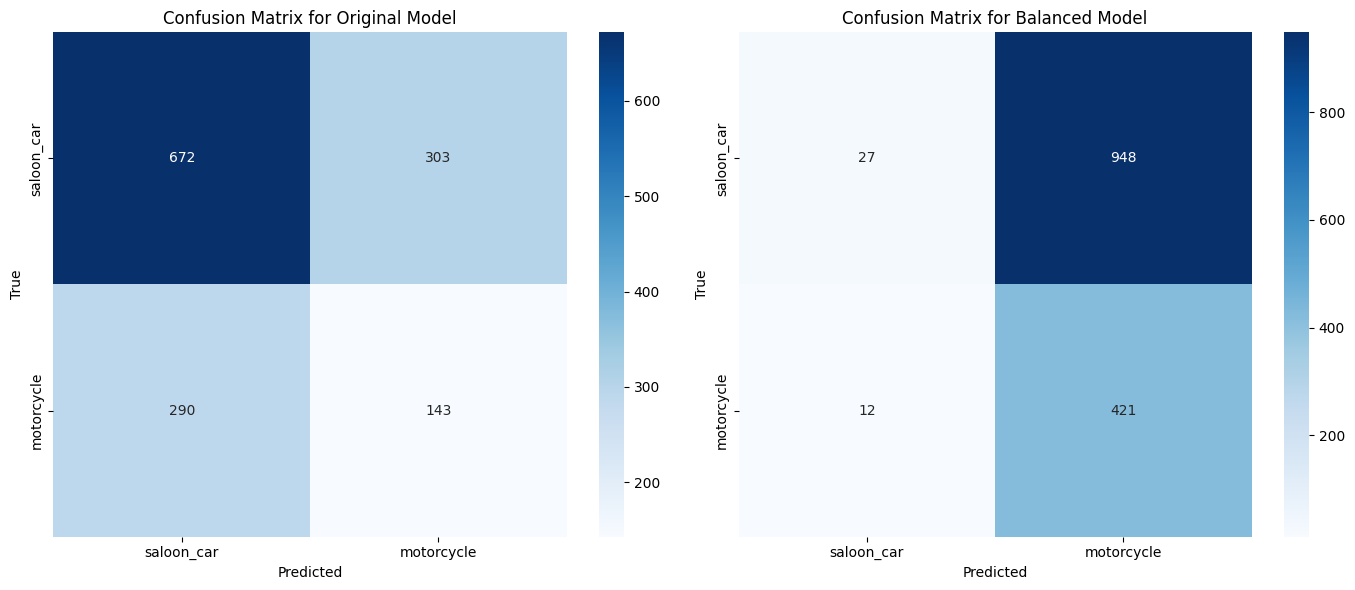

In [29]:
cm_original = confusion_matrix(true_classes, predicted_classes_original)
cm_balanced = confusion_matrix(true_classes, predicted_classes_balanced)


report_original = classification_report(true_classes, predicted_classes_original, target_names=['saloon_car', 'motorcycle'])
report_balanced = classification_report(true_classes, predicted_classes_balanced, target_names=['saloon_car', 'motorcycle'])


fpr_original, tpr_original, _ = roc_curve(true_classes, predictions_original)
roc_auc_original = auc(fpr_original, tpr_original)

fpr_balanced, tpr_balanced, _ = roc_curve(true_classes, predictions_balanced)
roc_auc_balanced = auc(fpr_balanced, tpr_balanced)


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', xticklabels=['saloon_car', 'motorcycle'], yticklabels=['saloon_car', 'motorcycle'])
plt.title('Confusion Matrix for Original Model')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1, 2, 2)
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues', xticklabels=['saloon_car', 'motorcycle'], yticklabels=['saloon_car', 'motorcycle'])
plt.title('Confusion Matrix for Balanced Model')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()



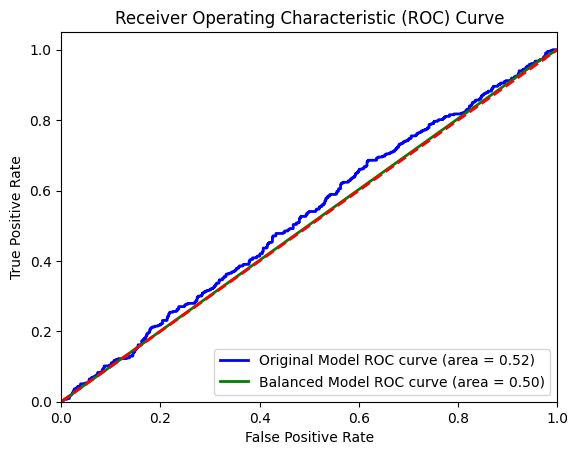

In [30]:

plt.figure()
plt.plot(fpr_original, tpr_original, color='blue', lw=2, label='Original Model ROC curve (area = %0.2f)' % roc_auc_original)
plt.plot(fpr_balanced, tpr_balanced, color='green', lw=2, label='Balanced Model ROC curve (area = %0.2f)' % roc_auc_balanced)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [31]:
print("Classification Report for Original Model")
print(report_original)
print("\nClassification Report for Balanced Model")
print(report_balanced)


Classification Report for Original Model
              precision    recall  f1-score   support

  saloon_car       0.70      0.69      0.69       975
  motorcycle       0.32      0.33      0.33       433

    accuracy                           0.58      1408
   macro avg       0.51      0.51      0.51      1408
weighted avg       0.58      0.58      0.58      1408


Classification Report for Balanced Model
              precision    recall  f1-score   support

  saloon_car       0.69      0.03      0.05       975
  motorcycle       0.31      0.97      0.47       433

    accuracy                           0.32      1408
   macro avg       0.50      0.50      0.26      1408
weighted avg       0.57      0.32      0.18      1408

